##Model building and Training

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [35]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def prepare_dataset(train_ratio=0.6, val_ratio=0.2, random_state=42):
    """
    Prepare the dataset by splitting it into train, validation, and test sets.

    Args:
        train_ratio (float): Ratio of data to be used for training. Default is 0.6.
        val_ratio (float): Ratio of data to be used for validation. Default is 0.2.
        random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
        train_dataset, val_dataset, test_dataset: TensorDataset objects for train, validation, and test sets.
    """

    if train_ratio + val_ratio >= 1:
        raise ValueError("train_ratio + val_ratio must be less than 1.")

    data = load_breast_cancer()
    X, y = data.data, data.target

    scaler = StandardScaler()  #Scale features to zero mean and unit variance
    X = scaler.fit_transform(X)

    test_ratio = 1 - (train_ratio + val_ratio)

    #Stratified split for train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(1 - train_ratio), stratify=y, random_state=random_state
    ) #stratify according to the label y

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(test_ratio / (test_ratio + val_ratio)), stratify=y_temp, random_state=random_state
    )

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    return train_dataset, val_dataset, test_dataset

1. First split X and y into training (X_train, y_train) and temporary (X_temp, y_temp) sets.
2. Split the temporary set into validation (X_val, y_val) and test (X_test, y_test) sets.

Why Stratified Split is better?

1.   Preserves Class Proportions- random splitting might result in one set having too few samples of the minority class, which can skew evaluation metrics

2.   Avoids Biased Training- the training set might contain mostly samples from the majority class. This can cause the model to be biased towards predicting the majority class, reducing its ability to generalize to the minority class.


In [36]:
batch_size = 32
train_ratio = 0.6
val_ratio = 0.2

# Prepare the dataset
train_set, val_set, test_set = prepare_dataset(train_ratio=train_ratio, val_ratio=val_ratio, random_state=42)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=lambda _: np.random.seed(seed)  # Ensures reproducibility
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False  # Validation loader does not shuffle data
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False  # Test loader does not shuffle data
)

In [37]:
class LinearNN(nn.Module):
    def __init__(self, input_size):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [38]:
#Only use for Google Colab because when limit is exhausted (only CPU is available)

def to_device(data, device):
    """
    Move data (tensor or list of tensors) to the specified device.
    Args:
        data: A tensor or a list/tuple of tensors to move.
        device: Target device (e.g., 'cuda' or 'cpu').
    Returns:
        Data moved to the specified device.
    """
    if isinstance(data, (list, tuple)):
        return [d.to(device) for d in data]
    return data.to(device)

In [39]:
def evaluate_model(model, dataloader, threshold=0.5):
    """
    Evaluate the model and return true labels, predictions, and probabilities.
    Args:
        model: Trained model.
        dataloader: DataLoader for evaluation.
        threshold: Probability threshold for binary classification.
    Returns:
        Tuple of (true_labels, predictions, probabilities).
    """
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            # Ensure inputs and labels are on the correct device
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).cpu().numpy().squeeze()
            preds = (outputs > threshold).astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

Functions used in outputs are-
* model(inputs): Feeds the batch of inputs into the model to get the raw output probabilities.
*   cpu(): Moves the output to the CPU (necessary if using a GPU).
*   .numpy(): Converts the tensor to a NumPy array for easier manipulation.
* .squeeze(): Removes unnecessary dimensions (e.g., [batch_size, 1] to [batch_size]).






In [40]:
model = LinearNN(input_size=30)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = to_device(model, device)

criterion = nn.BCELoss() #BCE loss because it is a binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #also tested with SGD and different lr

**Why Adam and LR = 0.001?**

Adam automatically adjusts learning rates per-parameter using moment estimates of gradients.

An initial learning rate of 0.001 is a well-tested baseline across many tasks which is reasonable balance between convergence speed and training stability.

In [41]:
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(batch_size, 30))

Layer (type:depth-idx)                   Output Shape              Param #
LinearNN                                 [32, 1]                   --
├─Linear: 1-1                            [32, 16]                  496
├─ReLU: 1-2                              [32, 16]                  --
├─Linear: 1-3                            [32, 32]                  544
├─ReLU: 1-4                              [32, 32]                  --
├─Linear: 1-5                            [32, 1]                   33
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [42]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 10
threshold = 0.5

train_accuracy = []
val_accuracy = []
train_f1 = []
val_f1 = []
validation_results = {"labels": None, "preds": None,"probs": None}
test_results = {"labels": None,"preds": None,"probs": None}
original_test_accuracy = None  # To use it later when perturbing the entire set for all features


for epoch in range(epochs):
    # Training Phase
    model.train()
    train_correct = 0
    train_total = 0
    train_preds = []
    train_labels = []

    for inputs, labels in train_loader:
        inputs, labels = to_device([inputs, labels], device)  # Ensures the data is on the same device as the model.
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        # Updates the model weights
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > threshold).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_accuracy_epoch = train_correct / train_total
    train_accuracy.append(train_accuracy_epoch)

    # Calculate train F1 score
    train_f1_epoch = f1_score(train_labels, train_preds)
    train_f1.append(train_f1_epoch)

    # Validation Phase
    val_labels, val_preds, val_probs = evaluate_model(model, val_loader, threshold=threshold)

    #used for ROC and AUC calculation
    validation_results["labels"] = val_labels
    validation_results["preds"] = val_preds
    validation_results["probs"] = val_probs

    # Calculate validation metrics
    val_accuracy_epoch = accuracy_score(val_labels, val_preds)
    val_f1_epoch = f1_score(val_labels, val_preds)
    val_accuracy.append(val_accuracy_epoch)
    val_f1.append(val_f1_epoch)

    print(f"Epoch {epoch + 1}/{epochs}, Train Acc: {train_accuracy_epoch:.2f}, Train F1: {train_f1_epoch:.2f}, "
          f"Val Acc: {val_accuracy_epoch:.2f}, Val F1: {val_f1_epoch:.2f}")


# Test Phase
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, threshold=threshold)
test_results["labels"] = test_labels
test_results["preds"] = test_preds
test_results["probs"] = test_probs

test_accuracy = accuracy_score(test_labels, test_preds)
original_test_accuracy = test_accuracy


print(f"Final Train Acc: {train_accuracy[-1]:.2f}, Final Val Acc: {val_accuracy[-1]:.2f}, Test Acc: {test_accuracy:.2f}")

Epoch 1/10, Train Acc: 0.73, Train F1: 0.81, Val Acc: 0.82, Val F1: 0.88
Epoch 2/10, Train Acc: 0.80, Train F1: 0.86, Val Acc: 0.87, Val F1: 0.91
Epoch 3/10, Train Acc: 0.86, Train F1: 0.90, Val Acc: 0.89, Val F1: 0.92
Epoch 4/10, Train Acc: 0.90, Train F1: 0.93, Val Acc: 0.95, Val F1: 0.96
Epoch 5/10, Train Acc: 0.92, Train F1: 0.94, Val Acc: 0.96, Val F1: 0.97
Epoch 6/10, Train Acc: 0.94, Train F1: 0.95, Val Acc: 0.96, Val F1: 0.97
Epoch 7/10, Train Acc: 0.94, Train F1: 0.95, Val Acc: 0.96, Val F1: 0.97
Epoch 8/10, Train Acc: 0.96, Train F1: 0.97, Val Acc: 0.96, Val F1: 0.97
Epoch 9/10, Train Acc: 0.96, Train F1: 0.97, Val Acc: 0.96, Val F1: 0.97
Epoch 10/10, Train Acc: 0.97, Train F1: 0.98, Val Acc: 0.97, Val F1: 0.98
Final Train Acc: 0.97, Final Val Acc: 0.97, Test Acc: 0.95


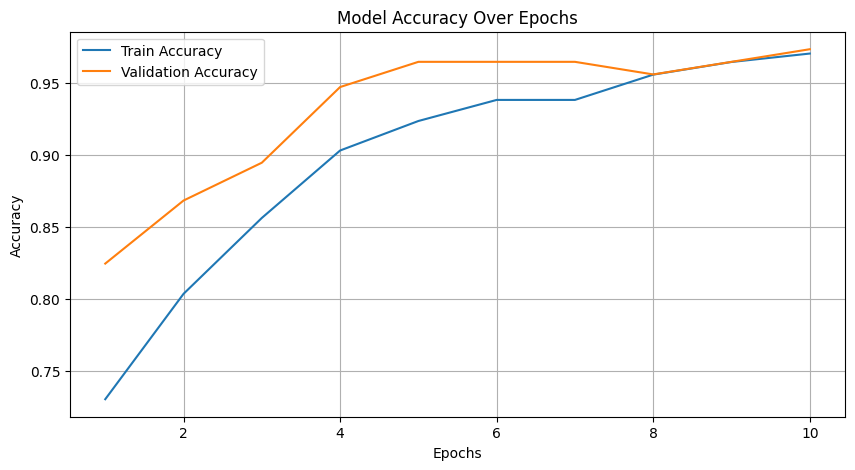

In [43]:
import matplotlib.pyplot as plt

# Plot Accuracy
epochs = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

The graph shows that both training and validation accuracy improve steadily over the epochs, with validation accuracy slightly ahead, suggesting the model is generalizing well. Leveling off toward end indicates the model has likely learned the patterns in the data without overfitting.

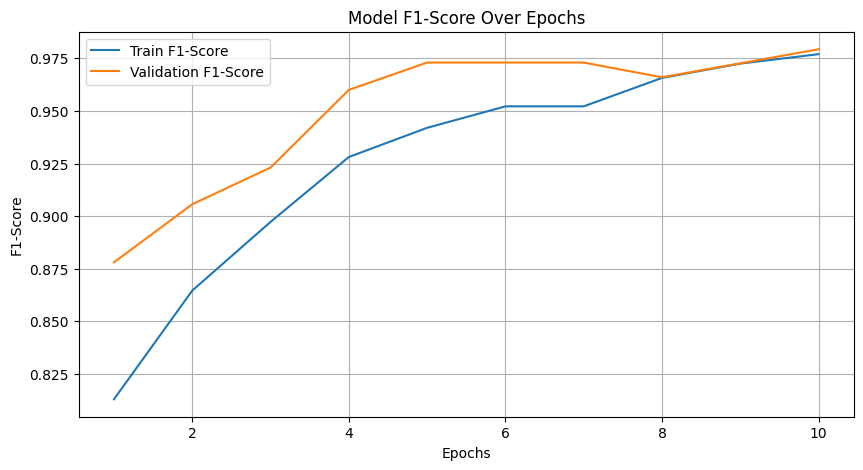

In [44]:
# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1, label='Train F1-Score')
plt.plot(epochs, val_f1, label='Validation F1-Score')
plt.title('Model F1-Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid()
plt.show()

**F1**=2×(precision x recall)/(precision+recall)

**Precision** measures how many of the predicted positives are actually positive.

**Recall** (or sensitivity) measures how many of the actual positives are predicted correctly.

Here our stratified split can help as model to learn from both classes adequately which might result in better F1 score

---



This graph illustrates the F1-Score during training and validation over the epochs. The validation F1-Score being consistently higher than the training F1-Score collaborates with previous graph that the model is generalizing well to unseen data. The upward trend in both scores indicates effective learning, with the model achieving good classification performance by the final epochs.

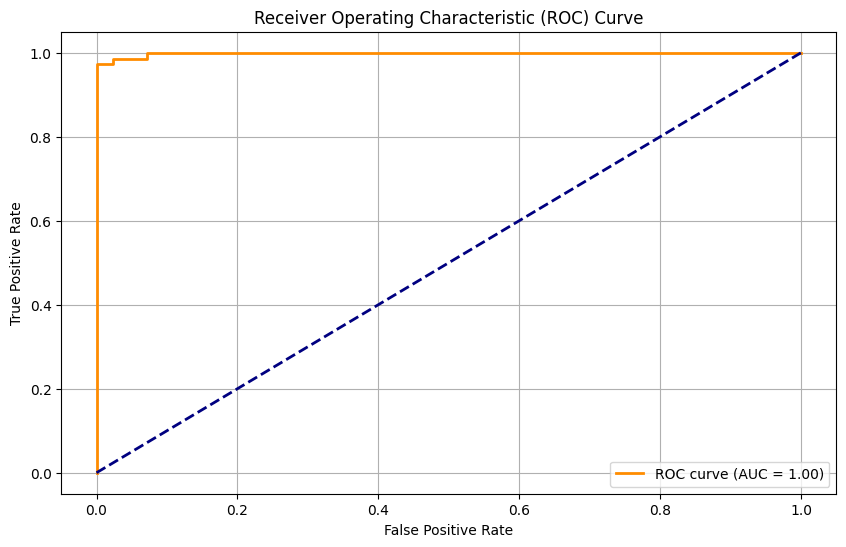

AUC: 0.9987


In [45]:
from sklearn.metrics import roc_curve, auc

true_labels_val = validation_results['labels']
probs_val = validation_results['probs']

# ROC and AUC calculation
fpr, tpr, thresholds = roc_curve(true_labels_val, probs_val)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.4f}")

ROC-focuses on how well a model can distinguish between two classes across different classification thresholds. ROC curve shows the model's ability to distinguish between positive and negative classe

TPR(recall or senstivity) = TP/(TP+FN)

FPR = FP/(FP+TN)

---

The curve approaching the top-left corner and an AUC score of near 1 indicates good performance, suggesting the model has a near-perfect trade-off between sensitivity and specificity.

##LIME

**What is feature attribution?**
Feature attributions refer to the numerical values assigned to individual features of an input sample by interpretability tools like LIME. Positive attributions indicate that increasing the feature value pushes the model's prediction closer to the predicted class and vice versa.

1.   Perturbing Input Samples: slightly modified versions of the input sample. The number of such perturbations is controlled by `num_samples` higher value means improved stability and accuracy of the surrogate model and the attributions but at cost of high computation time(crudely analogous to epochs for training but here we talk about perturbed neighbors around that particular instance and hence generates a richer local dataset)
2.   Each perturbed sample is passed through the model, and the corresponding predictions are collected.
3. LIME then uses the predictions from the perturbed samples to fit a simpler, interpretable model that approximates the behavior of the complex model locally (often a simple linear model).
4. The weights/coefficients from the this model indicate the importance of each feature for the prediction of the original input sample. These weights are what LIME provides as feature attributions.



### Setup for LIME

In [46]:
!pip install captum
from captum.attr import Lime

In [47]:
all_labels = test_results['labels']
all_preds = test_results['preds']

# Convert test labels, predictions, and probabilities to tensors
all_test_labels = torch.tensor(all_labels)
all_test_preds = torch.tensor(all_preds)

# Collect test inputs from the test loader, converts them in NumPy arrays, stores them in list
all_test_inputs = []
for inputs, _ in test_loader:
    all_test_inputs.extend(inputs.cpu().numpy())

all_test_inputs = torch.tensor(np.array(all_test_inputs)) #converts the list into a PyTorch tensor.

In [48]:
#comparing ground truth and predictions to collect samples of confusion matrix labels
true_positives = ((all_test_labels == 1) & (all_test_preds == 1)).nonzero(as_tuple=True)[0]
false_positives = ((all_test_labels == 0) & (all_test_preds == 1)).nonzero(as_tuple=True)[0]
true_negatives = ((all_test_labels == 0) & (all_test_preds == 0)).nonzero(as_tuple=True)[0]
false_negatives = ((all_test_labels == 1) & (all_test_preds == 0)).nonzero(as_tuple=True)[0]

def get_one_example(indices):
    return indices[0].item() if len(indices) > 0 else None

tp_idx = get_one_example(true_positives)
fp_idx = get_one_example(false_positives)
tn_idx = get_one_example(true_negatives)
fn_idx = get_one_example(false_negatives)

selected_indices = [tp_idx, fp_idx, tn_idx, fn_idx]
selected_indices = [idx for idx in selected_indices if idx is not None]

print("Selected Indices:")
print("TP:", tp_idx, "FP:", fp_idx, "TN:", tn_idx, "FN:", fn_idx)

Selected Indices:
TP: 0 FP: 3 TN: 1 FN: 39


In [49]:
#  Forward function for LIME
def forward_func(x):
    model.eval()
    with torch.no_grad():
        return model(x)

lime = Lime(forward_func)

X_selected = all_test_inputs[selected_indices].to(device) #features for selected indices
y_selected = all_test_labels[selected_indices] #labels for selected indices(ground truth)

In [50]:
def compute_lime_attribution(model, lime, input_sample, num_samples=100):
    """Compute LIME attributions for a given input sample."""

    input_sample = input_sample.unsqueeze(0).to(device)
    lime_attr = lime.attribute(input_sample, n_samples=num_samples)
    return lime_attr.squeeze().cpu().detach().numpy()

### Evaluation metric 1: Time
Time taken to generate the explanation for each sample (depends on `num_samples`, higher the value more time taken).

In [51]:
import time

def compute_and_store_attributions(model, lime, selected_indices, num_samples=300, threshold=1e-4):
    """
    Compute LIME attributions for selected samples and measure timing.

    Args:
        model: Trained model.
        lime: LIME object for computing attributions.
        inputs: Tensor of all test inputs.
        labels: Tensor of all test labels.
        selected_indices: List of selected sample indices.
        num_samples: Number of samples for LIME perturbation.
        threshold: Threshold for printing significant attributions(a lot of attributions will have 0 or near 0 value).

    Returns:
        attributions (dict): Dictionary mapping sample indices to their attributions.
        times (list): List of time taken for each sample.
    """
    attributions = {}
    times = []

    # Compute and store attributions and timing
    for i, idx in enumerate(selected_indices):
        input_sample = X_selected[i].unsqueeze(0)  # Preparing selected sample, we reshape the input sample from a 1D tensor to a 2D tensor so it is compatible with the model for forward passes

        # Time the attribution calculation
        start_time = time.time()
        lime_attr = compute_lime_attribution(model, lime, input_sample.squeeze(0), num_samples=num_samples)
        end_time = time.time()
        times.append(end_time - start_time)

        attributions[idx] = lime_attr

        # features with absolute attribution values greater than the threshold(non zero)
        print(f"\nLIME Explanation for Sample Index {idx} (Ground Truth: {y_selected[i].item()}, Prediction: {all_test_preds[idx].item()}):")
        print("Feature Index: Attribution:")
        for feat_idx, attr_val in enumerate(lime_attr):
            if abs(attr_val) > threshold:
                print(f"Feature {feat_idx}: {attr_val:.4f}")

        print(f"Time taken for Sample Index {idx}: {times[-1]:.4f} seconds")

    return attributions, times


In [52]:
attributions, times = compute_and_store_attributions(
    model=model,
    lime=lime,
    selected_indices=selected_indices,
    num_samples=300,
    threshold=1e-4
)


LIME Explanation for Sample Index 0 (Ground Truth: 1.0, Prediction: 1):
Feature Index: Attribution:
Feature 1: 0.0333
Feature 21: 0.0057
Feature 27: -0.0022
Time taken for Sample Index 0: 0.5053 seconds

LIME Explanation for Sample Index 3 (Ground Truth: 0.0, Prediction: 1):
Feature Index: Attribution:
Feature 1: 0.0413
Feature 13: 0.0116
Feature 18: -0.0072
Feature 21: 0.0064
Feature 28: 0.0040
Feature 29: -0.0041
Time taken for Sample Index 3: 0.2932 seconds

LIME Explanation for Sample Index 1 (Ground Truth: 0.0, Prediction: 0):
Feature Index: Attribution:
Feature 0: -0.0399
Feature 2: -0.0166
Feature 3: -0.0231
Feature 23: -0.0443
Time taken for Sample Index 1: 0.3243 seconds

LIME Explanation for Sample Index 39 (Ground Truth: 1.0, Prediction: 0):
Feature Index: Attribution:
Feature 1: 0.0130
Feature 3: 0.0040
Feature 5: -0.0252
Feature 12: 0.0031
Feature 13: 0.0297
Feature 23: 0.0006
Feature 24: -0.0033
Feature 25: -0.0176
Feature 26: -0.0465
Feature 27: -0.0111
Feature 28: -0.0

### Evaluation metric 2: Parsimony
Parsimony refers to the number of features whose attributions (after normalization) have an absolute value greater than a threshold τ.

In [53]:
def compute_parsimonies_and_features(attributions, selected_indices, tau=0.1):
    """
    Compute parsimonies and top contributing features for selected samples.

    Args:
        attributions (dict): Dictionary of LIME attributions for each sample.
        selected_indices (list): List of sample indices for computation.
        tau (float): Threshold for parsimony significance.

    Returns:
        parsimonies (list): List of parsimony counts for each sample.
        top_features_dict (dict): Dictionary of top features for each sample, with raw attributions.
    """
    parsimonies = []
    top_features_dict = {}

    for idx in selected_indices:
        lime_attr = attributions[idx]

        # Normalization
        epsilon = 1e-10  # Avoid division by zero (edge case)
        lime_attr = lime_attr.astype(np.float64)  # Higher precision
        lime_attr_scaled = lime_attr / (max(abs(lime_attr)) + epsilon)  # Absolute Max Scaling

        # Identify features contributing to parsimony
        significant_features = [(feature_idx, lime_attr[feature_idx], lime_attr_scaled[feature_idx])
                                for feature_idx in range(len(lime_attr))
                                if abs(lime_attr_scaled[feature_idx]) > tau]

        # Sort significant features by absolute value of raw attributions in descending order
        significant_features = sorted(significant_features, key=lambda x: abs(x[1]), reverse=True)

        # Compute parsimony (number of significant features)
        parsimony = len(significant_features)
        parsimonies.append(parsimony)

        top_features_dict[idx] = [(feat[0], feat[1]) for feat in significant_features]  # Keep raw attribution

        print(f"Parsimony for Sample Index {idx}: {parsimony} features")
        print("Significant Features (Feature Index: Raw Attribution, Scaled Attribution):")
        for feature_idx, raw_attr_val, scaled_attr_val in significant_features:
            print(f"Feature {feature_idx}: Raw = {raw_attr_val:.4f}, Scaled = {scaled_attr_val:.4f}")
        print("\n")

    return parsimonies, top_features_dict

In [54]:
parsimonies, top_features_dict = compute_parsimonies_and_features(
    attributions=attributions,
    selected_indices=selected_indices,
    tau=0.1
)

Parsimony for Sample Index 0: 2 features
Significant Features (Feature Index: Raw Attribution, Scaled Attribution):
Feature 1: Raw = 0.0333, Scaled = 1.0000
Feature 21: Raw = 0.0057, Scaled = 0.1700


Parsimony for Sample Index 3: 4 features
Significant Features (Feature Index: Raw Attribution, Scaled Attribution):
Feature 1: Raw = 0.0413, Scaled = 1.0000
Feature 13: Raw = 0.0116, Scaled = 0.2801
Feature 18: Raw = -0.0072, Scaled = -0.1739
Feature 21: Raw = 0.0064, Scaled = 0.1560


Parsimony for Sample Index 1: 4 features
Significant Features (Feature Index: Raw Attribution, Scaled Attribution):
Feature 23: Raw = -0.0443, Scaled = -1.0000
Feature 0: Raw = -0.0399, Scaled = -0.9006
Feature 3: Raw = -0.0231, Scaled = -0.5216
Feature 2: Raw = -0.0166, Scaled = -0.3747


Parsimony for Sample Index 39: 7 features
Significant Features (Feature Index: Raw Attribution, Scaled Attribution):
Feature 26: Raw = -0.0465, Scaled = -1.0000
Feature 28: Raw = -0.0427, Scaled = -0.9190
Feature 13: Raw 

**Choice of Scaling**- Absolute Max Scaling: scaled value= value/ max(abs(values))

**Reason**- It provides a normalized scale of [−1,1], preserves the sign of attributions, and focuses on relative importance.


### Evaluation metric 3: Correctness
Evaluate the explanation using a perturbation curve. Perturb
features with the highest importance scores and observe the model's output

#### Peturbing only top features

In [55]:
def perturb_features(data, features, perturb_value=0):
    """
    Perturb specific features in a sample or dataset.

    Parameters:
        data (torch.Tensor): A single sample (1D tensor) or dataset (2D tensor).
        features (list): List of feature indices to perturb.
        perturb_value (float, torch.Tensor, or list): Value(s) to replace the selected features with.

    Returns:
        torch.Tensor: Perturbed sample or dataset.
    """
    perturbed_data = data.clone()
    if data.dim() == 1:  # Single sample (1D tensor)
        if isinstance(perturb_value, (int, float)):  # If perturb_value is a single value
            perturbed_data[features] = perturb_value  # Apply the value to all specified features
        else:  # If perturb_value is iterable (e.g., list, tensor)
            for i, feature in enumerate(features):
                perturbed_data[feature] = perturb_value[i]  # Change: Use the corresponding value
    elif data.dim() == 2:  # Dataset (2D tensor)
        perturbed_data[:, features] = perturb_value
    else:
        raise ValueError("Input data must be a 1D or 2D tensor.")
    return perturbed_data

In [56]:
confusion_labels = ["TP", "FP", "TN", "FN"]
feature_means = all_test_inputs.mean(dim=0)

In [57]:
def perform_progressive_perturbation(selected_indices, X_selected, feature_means, top_features_dict, max_features_to_perturb=10):
    """
    Perform progressive perturbation for each selected sample.

    Args:
        selected_indices (list): Indices of selected samples.
        X_selected (torch.Tensor): Input samples corresponding to selected indices.
        feature_means (torch.Tensor): Per-feature mean values for perturbation.
        top_features_dict (dict): Dictionary of top contributing features for each sample.
        max_features_to_perturb (int): Maximum number of features to perturb.

    Returns:
        dict: A dictionary containing confidence scores for each sample.
    """
    confidence_scores = {idx: [] for idx in selected_indices}

    for i, idx in enumerate(selected_indices):
        input_sample = X_selected[i]
        top_features = [feat_idx for feat_idx, _ in top_features_dict[idx]][:max_features_to_perturb]

        # original confidence
        original_output = forward_func(input_sample.unsqueeze(0))  # Add batch dim for model
        confidence_scores[idx].append(original_output.item())  # Store initial confidence score

        # Perturb on a clone
        perturbed_sample = input_sample.clone()

        # Sequentially perturb top features (progressive perturbation)
        for num_perturb in range(1, max_features_to_perturb + 1):
            features_to_perturb = top_features[:num_perturb]

            # Perturb the selected features using per-feature mean values
            perturbed_sample = perturb_features(
                perturbed_sample,
                features_to_perturb,
                perturb_value=feature_means[features_to_perturb],
            )

            output = forward_func(perturbed_sample.unsqueeze(0))  # Add batch dim for model
            confidence_scores[idx].append(output.item())  # Store confidence score

    return confidence_scores


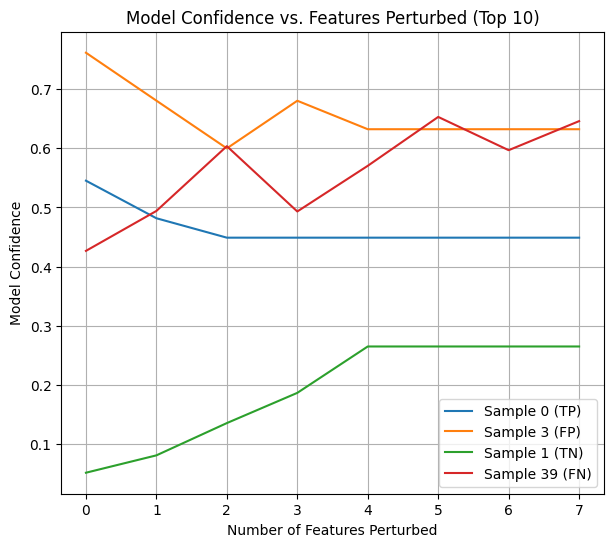

In [58]:
max_features_to_perturb = 7
confidence_scores_7 = perform_progressive_perturbation(
    selected_indices=selected_indices,
    X_selected=X_selected,
    feature_means=feature_means,
    top_features_dict=top_features_dict,
    max_features_to_perturb=max_features_to_perturb
)

plt.figure(figsize=(7, 6))
for i, idx in enumerate(selected_indices):
    label = f"Sample {idx} ({confusion_labels[i]})"
    plt.plot(range(0, max_features_to_perturb + 1), confidence_scores_7[idx], label=label)

plt.xticks(range(0, max_features_to_perturb + 1, 1))
plt.xlabel("Number of Features Perturbed")
plt.ylabel("Model Confidence")
plt.title("Model Confidence vs. Features Perturbed (Top 10)")
plt.legend()
plt.grid()
plt.show()

In [59]:
sample_idx = 39
sample_index_in_X_selected = 3  # X_selected[3] corresponds to Sample Index 39
if sample_idx in top_features_dict:
    print(f"Comparison for Sample Index {sample_idx} (X_selected[{sample_index_in_X_selected}]):\n")
    significant_features = top_features_dict[sample_idx]

    print("Feature Index | Original Value in X_selected | Perturbed Value (Feature Mean) | Raw Attribution")
    print("-" * 100)
    for feature_idx, raw_attr_val in significant_features:
        original_value = X_selected[sample_index_in_X_selected, feature_idx].item()
        perturbed_value = feature_means[feature_idx].item()
        print(f"{feature_idx:13} | {original_value:26.4f} | {perturbed_value:30.4f} | {raw_attr_val:15.4f}")

Comparison for Sample Index 39 (X_selected[3]):

Feature Index | Original Value in X_selected | Perturbed Value (Feature Mean) | Raw Attribution
----------------------------------------------------------------------------------------------------
           26 |                     1.0248 |                        -0.0614 |         -0.0465
           28 |                     1.0131 |                        -0.1186 |         -0.0427
           13 |                    -0.6023 |                         0.2341 |          0.0297
            5 |                     0.9316 |                         0.0688 |         -0.0252
           25 |                     1.4303 |                        -0.0490 |         -0.0176
            1 |                    -0.7981 |                        -0.0108 |          0.0130
           27 |                     0.8556 |                         0.0001 |         -0.0111


**Analysis of Perturbation Results**

1. **Sample 3 (FP)**: The model's confidence dropped from ~0.75 to ~0.6 after perturbations, indicating reduced certainty in its incorrect prediction, but the classification remains false.

2. **Sample 0 (TP)**: Confidence dropped below 0.5 after perturbations, flipping the prediction from correct (positive) to incorrect (negative). Indicates sensitivity to key features.

3. **Sample 39 (FN)**: Confidence increased from ~0.4 to ~0.6, flipping the prediction from incorrect (negative) to correct (positive). Perturbations corrected the model's mistake and indicates calculated important features reponsible for making (incorrect) prediction affected the model's confidence when perturbed.

4. **Sample 1 (TN)**: Confidence increased (still < 0.5), showing reduced certainty in its correct (negative) prediction but no misclassification occurred.

**Conclusion**: Perturbations effectively reveal the model's dependence on key features, highlighting both strengths and vulnerabilities in its predictions.


####**EXTRA** : Perturbing all 30 features for our selected samples

In [60]:
num_features_to_perturb = 30
model_confidences = {idx: [] for idx in selected_indices}

for i, idx in enumerate(selected_indices):
    input_sample = X_selected[i]
    lime_attr = attributions[idx] #using all attributions caluclated

    # Sort features by absolute LIME attribution
    sorted_features = np.argsort(-np.abs(lime_attr))

    perturbed_sample = input_sample.clone()

    # Compute original confidence
    original_confidence = forward_func(input_sample.unsqueeze(0)).item()
    model_confidences[idx].append(original_confidence)

    for num_perturb in range(1, num_features_to_perturb + 1):
        features_to_perturb = sorted_features[:num_perturb]

        # Perturb the selected features using per-feature mean values
        perturbed_sample = perturb_features(
            perturbed_sample,
            features_to_perturb,
            perturb_value=feature_means[features_to_perturb],
        )
        confidence = forward_func(perturbed_sample.unsqueeze(0)).item()
        model_confidences[idx].append(confidence)

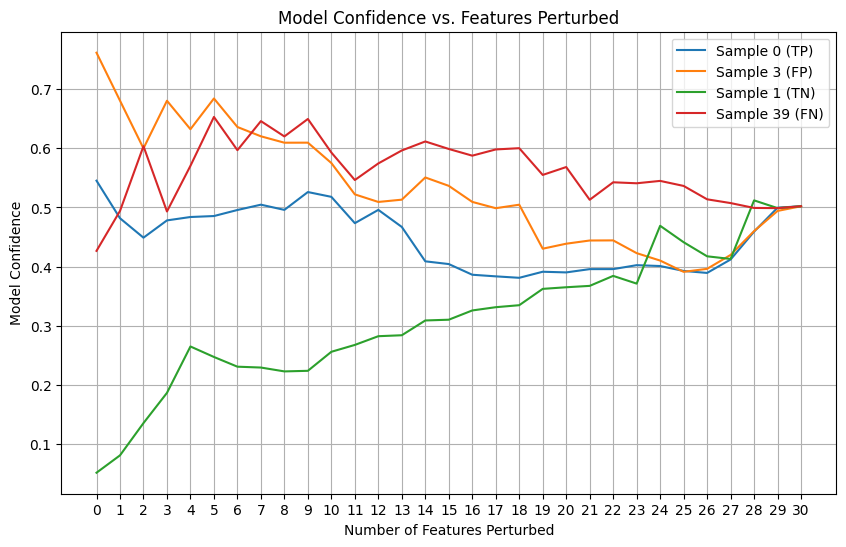

In [61]:
plt.figure(figsize=(10, 6))
for i, idx in enumerate(selected_indices):
    label = f"Sample {idx} ({confusion_labels[i]})"
    plt.plot(
        range(0, num_features_to_perturb + 1),
        model_confidences[idx],
        label=label,
    )

plt.xticks(range(0, num_features_to_perturb + 1, 1))
plt.xlabel("Number of Features Perturbed")
plt.ylabel("Model Confidence")
plt.title("Model Confidence vs. Features Perturbed")
plt.legend()
plt.grid()
plt.show()

**Analysis**

If the model is well-calibrated,once enough important features(in this case all features) have been replaced by average values, the input starts to look very “generic,” not clearly belonging to either class. As a result, the model has no strong reason to push its confidence toward 0 or 1.

This consistency(0.5 confidence across all samples) simply reinforces that when the model is starved of relevant features, it reverts to an “uncertain” guess.

#### Perturbing entire Test Set(114 Samples)

In [62]:
def progressive_perturbation_analysis(model, lime, test_inputs, feature_means, test_labels, num_samples=100, threshold=0.5):
    """
    Perform progressive perturbation analysis with dataset-wide accuracy calculation and AUPC computation.
    Args:
        model: Trained model.
        lime: LIME object for computing attributions.
        test_inputs: Tensor of test inputs.
        feature_means: Tensor of per-feature means for perturbation.
        test_labels: Tensor of test labels.
        num_samples: Number of samples for LIME perturbation.
        threshold: Probability threshold for binary classification.
    Returns:
        dataset_accuracies: List of dataset-wide accuracies at each perturbation step.
        all_lime_attributions: Precomputed LIME attributions for all test samples.
        aupc: Area Under the Perturbation Curve.
    """
    device = test_inputs.device
    num_features = test_inputs.shape[1]
    perturbation_steps = np.arange(1, num_features + 1)
    dataset_accuracies = []
    all_lime_attributions = []

    # Step 1: Compute and save LIME attributions
    print("Computing LIME attributions for all samples...")
    for input_sample in test_inputs:
        lime_attr = compute_lime_attribution(model, lime, input_sample, num_samples=num_samples)
        all_lime_attributions.append(lime_attr)
    all_lime_attributions = np.array(all_lime_attributions)  # Convert to NumPy array for easier manipulation

    # Step 2: Perturb features progressively
    print("Perturbing features progressively and evaluating...")
    perturbed_inputs = test_inputs.clone()  # Clone test inputs for perturbation
    for step in perturbation_steps:
        for i in range(len(test_inputs)):
            sorted_features = np.argsort(-np.abs(all_lime_attributions[i]))[:step]  # Top `step` features
            perturbed_inputs[i] = perturb_features(
                perturbed_inputs[i],  # Perturb progressively
                sorted_features,
                perturb_value=feature_means[sorted_features]
            )

        # Step 3: Evaluate model accuracy on the perturbed dataset
        _, perturbed_preds, _ = evaluate_model(model, [(perturbed_inputs, test_labels)], threshold=threshold)
        accuracy = accuracy_score(test_labels.cpu().numpy(), perturbed_preds)
        dataset_accuracies.append(accuracy)

    # Step 4: Calculate AUPC
    aupc = np.trapz(dataset_accuracies, dx=1)
    print(f"AUPC (Area Under the Perturbation Curve): {aupc:.4f}")

    # Step 5: Save attributions for reuse and return results
    print(f"Perturbation analysis completed. Saved attributions for {len(all_lime_attributions)} samples.")
    return dataset_accuracies, all_lime_attributions, aupc

**How are we perturbing in this case?(an example)**

> Step 1: Perturb the Most Important Feature Across All Samples

*Sample 0* : Original `[0.5, -0.2, 1.0, -0.5, 0.3]`

Perturb Feature 2 (most important): `[0.5, -0.2, mean, -0.5, 0.3]`

*Sample 1* : Original `[0.8, 0.4, -0.7, 0.1, -0.6]`

Perturb Feature 0 (most important): `[mean, 0.4, -0.7, 0.1, -0.6]`

--> Calculate Accuracy


---

> Step 2: Perturb the Two Most Important Features Across All Samples

*Sample 0* : After Step 1 `[0.5, -0.2, mean, -0.5, 0.3]`

Perturb Features 2 and 3: `[0.5, -0.2, mean, mean, 0.3]`

*Sample 1* : After Step 1 `[mean, 0.4, -0.7, 0.1, -0.6]`

Perturb Features 0 and 4: `[mean, 0.4, -0.7, 0.1, mean]`

--> Calculate Accuracy

In [63]:
dataset_accuracies, all_lime_attributions, aupc = progressive_perturbation_analysis(
    model=model,
    lime=lime,
    test_inputs=all_test_inputs,
    feature_means=feature_means,
    test_labels=all_test_labels,
    num_samples=300,
    threshold=0.5
)

Computing LIME attributions for all samples...
Perturbing features progressively and evaluating...
AUPC (Area Under the Perturbation Curve): 25.4211
Perturbation analysis completed. Saved attributions for 114 samples.


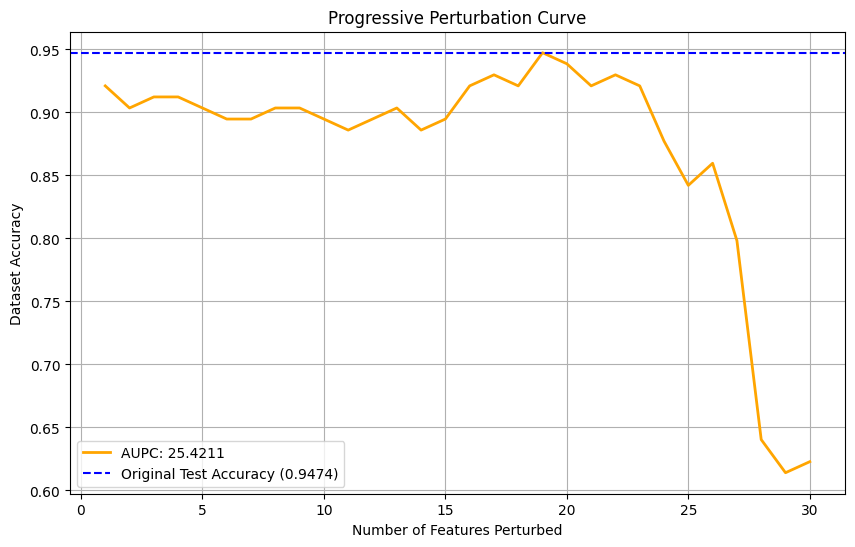

In [64]:
#plotting progressive perturbation
perturbation_steps = np.arange(1, all_test_inputs.shape[1] + 1)
plt.figure(figsize=(10, 6))
plt.plot(perturbation_steps, dataset_accuracies, label=f"AUPC: {aupc:.4f}", lw=2, color='orange')
plt.axhline(y=original_test_accuracy, color='blue', linestyle='--', label=f"Original Test Accuracy ({original_test_accuracy:.4f})")
plt.xlabel("Number of Features Perturbed")
plt.ylabel("Dataset Accuracy")
plt.title("Progressive Perturbation Curve")
plt.legend()
plt.grid()
plt.show()

**Analysis**



1.   The first perturbation decreases accuracy with less than 95%(baseline).  
2.   Gradual decrease(expected steep decrease) till 15 perturbed. Why?
      1. Often datasets have correlated data. Even if most important feature is perturbed, other correlated features may partially compensate for its absence.
      2. Deep learning models are designed to be robust to minor perturbations (perturbation with mean value is less drastic than extreme values).
      3. “High local influence” does not always translate into “changing it will significantly reduce global accuracy.”
3.  Jump in accuracy from features 15-20. There could be 2 schools of thought-
      
      1. The model could be latching on to certain features that happen to be very discriminative for this data but do not genuinely help in generalizing to unseen data.
      2. A large attribution (positive/negative) may indicate the model is relying on that feature. But relying on something does not necessarily mean it is helpful to the correct label, sometimes it is a misleading signal the model learned to use. By perturbing that “influential but misleading” feature, you effectively remove the model’s use of it, and thus may reduce errors the model was making because of it hence jumping the accuracy.
      
4. Possible reasons for significant drop after perturbing features after 20-
    1. Very few features left to make predictions. After enough features are perturbed, the model simply has too little informative signal left to maintain accuracy.
    2. Progressive perturbation is cumulative. Even if many of the first 20 features didn’t critically hurt accuracy, their combined removal or neutralization still chips away at the model’s predictive capacity.
    3. Features 21+ might not always top the local‐importance charts for every individual sample, but globally, they may be essential across many test samples.